<a href="https://colab.research.google.com/github/shielamms/AI-and-Data-Analysis/blob/master/Finding_My_FIFA_Dream_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **My FIFA 2020 Dream Team**
Notebook written by Shiela Sandoval

##### Given the [Kaggle FIFA 20 complete player dataset](https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset?select=players_20.csv), I'm putting together a notebook for analyzing the personal and professional data of football players all over the world, with the goal of forming my Dream Team consisting of the best players in each position.
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

### **Getting the Data**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
import re
import seaborn as sns

In [3]:
from google.colab import files

uploaded = files.upload()

Saving players_20.csv to players_20.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['players_20.csv']))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Columns: 104 entries, sofifa_id to rb
dtypes: float64(16), int64(45), object(43)
memory usage: 14.5+ MB


So we have 18,278 players and 104 features.

### **Contents**

```
Data Preprocessing
  > Selecting relevant features
  > Transforming features
  > Handling missing values
Visualizations
  > Nationality
    > Nationality statistics
    > Overall score by nationality
  > Age
    > Youngest players
    > Oldest players
  > Top-paying Players
    > In the world
    > Per specific country
  > Top Players by Overall Rating
  > Top Players by Position

```

### **Data Preprocessing**

##### **Selecting Relevant Features**

There are 104 features to choose from, so it might be too time-consuming to look at inidivual features. To at least make the 104 features easier to digest, we'll start by looking at the numeric features first, and then at the features of type 'object' (i.e, strings).

In [6]:
numerics = df.select_dtypes(exclude=['object'])
numerics.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['sofifa_id', 'age', 'height_cm', 'weight_kg', 'overall', 'potential',
       'value_eur', 'wage_eur', 'international_reputation', 'weak_foot',
       'skill_moves', 'release_clause_eur', 'team_jersey_number',
       'contract_valid_until', 'nation_jersey_number', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interc

In [7]:
objs = df.select_dtypes(include=['object'])
objs.columns

Index(['player_url', 'short_name', 'long_name', 'dob', 'nationality', 'club',
       'player_positions', 'preferred_foot', 'work_rate', 'body_type',
       'real_face', 'player_tags', 'team_position', 'loaned_from', 'joined',
       'nation_position', 'player_traits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf',
       'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
       'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object')

Once we've divided the features into smaller groups, we can hand-pick the features we want to analyze.

In [8]:
numeric_features = ['age', 'height_cm', 'weight_kg', 'overall', 'potential', 'value_eur', 'wage_eur']

In [9]:
attacking_features = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys']
skill_features = ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control']
movement_features = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance']
power_features = ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots']
mentality_features = ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure']
defending_features = ['defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']
goalkeeping_features = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

In [10]:
position_score_features = ['ls', 'st', 'rs', 'lw', 'lf', 'cf',
       'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
       'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']

In [11]:
personal_features = ['short_name', 'nationality', 'club', 'player_positions', 'team_position', 'preferred_foot']

In [12]:
data = df[personal_features + numeric_features + attacking_features + skill_features + movement_features + power_features
          + mentality_features + defending_features + goalkeeping_features + position_score_features]
data.head()

,short_name,nationality,club,player_positions,team_position,preferred_foot,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,L. Messi,Argentina,FC Barcelona,"RW, CF, ST",RW,Left,32,170,72,94,94,95500000,565000,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,Cristiano Ronaldo,Portugal,Juventus,"ST, LW",LW,Right,34,187,83,93,93,58500000,405000,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,Neymar Jr,Brazil,Paris Saint-Germain,"LW, CAM",CAM,Right,27,175,68,92,92,105500000,290000,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,J. Oblak,Slovenia,Atlético Madrid,GK,GK,Right,26,188,87,91,93,77500000,125000,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E. Hazard,Belgium,Real Madrid,"LW, CF",LW,Right,28,175,74,91,91,90000000,470000,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


##### **Transforming Features**

Observation with the data: the position score features are strings, instead of numeric values. This is because a score is affixed with +x or -x, indicating the difference from last year's score. Since last year's score is irrelevant in our case, we need to remove these affixes and retain only the numeric score of this year.

In [13]:
data[position_score_features].dtypes

ls     object
st     object
rs     object
lw     object
lf     object
cf     object
rf     object
rw     object
lam    object
cam    object
ram    object
lm     object
lcm    object
cm     object
rcm    object
rm     object
lwb    object
ldm    object
cdm    object
rdm    object
rwb    object
lb     object
lcb    object
cb     object
rcb    object
rb     object
dtype: object

In [14]:
# Remove the +x and -x affixes and convert the values into integers
for col_name in position_score_features:
  data[col_name] = data[col_name].astype('str')
  # data[col_name] = data[col_name].fillna('')

  data[col_name] = data[col_name].str.replace(r'\+[0-9]+', '').replace('nan', 0)
  data[col_name] = data[col_name].astype('int')

data[position_score_features].head()

,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63
1,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61
2,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61


Now let's take a look at the data type of the other numeric features. We'll use unique() to confirm if there are varying numeric types.

In [15]:
data[numeric_features + attacking_features + skill_features + movement_features + power_features
          + mentality_features + defending_features + goalkeeping_features].dtypes.unique()

array([dtype('int64')], dtype=object)

Using our knowledge of the dataset, we can infer that the features for *movement*, *power*, *mentality*, *defending*, and *goalkeeping*, *overall*, and *potential* are integer scores from 0 to 100. The other numeric features, such as *age*, *height_cm*, *weight_cm*, *value_eur*, and *wage_eur* are also integers but with varying ranges and magnitudes (i.e., *age* is a value from 16-42, while *value_eur* is a value from 0 to 105.5 billion). If we were to build a machine learning model that utlizes these numeric features of varying magnitudes, then we will need to scale the features using some scaling method. But in this case, we're just interested in visualizing these features, so we will not be scaling anything here at least. Also, the exact euro value and wage of players might be useful for us when we want to know who is the most valuable and the highest-paying player.

In [16]:
data[numeric_features].describe()

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur
count,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,1.827800e+04,18278.000000
mean,25.283291,181.362184,75.276343,66.244994,71.546887,2.484038e+06,9456.942773
std,4.656964,6.756961,7.047744,6.949953,6.139669,5.585481e+06,21351.714095
min,16.000000,156.000000,50.000000,48.000000,49.000000,0.000000e+00,0.000000
25%,22.000000,177.000000,70.000000,62.000000,67.000000,3.250000e+05,1000.000000
50%,25.000000,181.000000,75.000000,66.000000,71.000000,7.000000e+05,3000.000000
75%,29.000000,186.000000,80.000000,71.000000,75.000000,2.100000e+06,8000.000000
max,42.000000,205.000000,110.000000,94.000000,95.000000,1.055000e+08,565000.000000


### **Nationality**

In [17]:
len(data['nationality'].unique())

162

In [18]:
count_per_nation = data[['short_name', 'nationality']].groupby(['nationality']).agg(count=('nationality', 'count')).sort_values(by=['count'], ascending=False)

In [19]:
# Get the top 10 countries with the most FIFA players
top_nations_player_cnt = count_per_nation.iloc[0:10].reset_index()
top_nations_player_cnt

,nationality,count
0,England,1667
1,Germany,1216
2,Spain,1035
3,France,984
4,Argentina,886
5,Brazil,824
6,Italy,732
7,Colombia,591
8,Japan,453
9,Netherlands,416


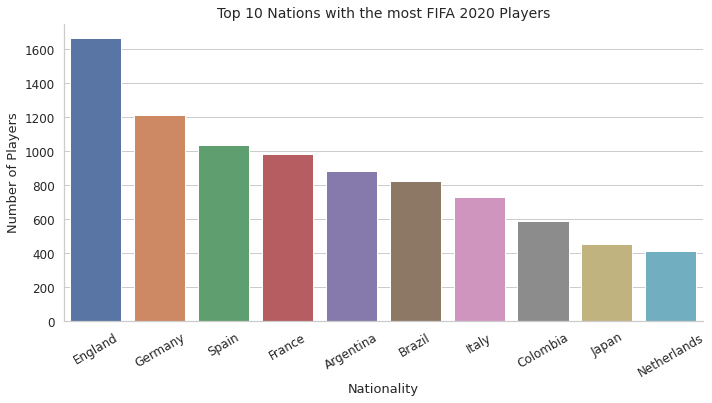

In [20]:
sns.set(style='whitegrid')

sns.catplot('nationality', 'count', data=top_nations_player_cnt, kind='bar', aspect=2, height=5)

plt.xticks(rotation=30, size=12)
plt.yticks(size=12)
plt.xlabel('Nationality', size=13)
plt.ylabel('Number of Players', size=13)
plt.title('Top 10 Nations with the most FIFA 2020 Players', size=14)
plt.show()

##### **Overall Score by Nationality**

In [21]:
# Get average overall score of players by Nationality
mean_overall_by_nationality = data[['overall', 'nationality']].groupby('nationality').mean().reset_index()

In [22]:
def plot_overall_by_nationality(df):
  sns.set(style='whitegrid')

  sns.catplot('nationality', 'overall', data=df, kind='bar', aspect=3, height=5)
  plt.xticks(rotation=30, size=13)
  plt.yticks([])
  plt.xlabel('Nationality', size=13)
  plt.ylabel('Overall', size=13)
  plt.title('Comparison of 12 Nationalities by Average Overall Score ', size=14)

  for i, p in enumerate(df['overall'].values.tolist()):
    plt.text(i, round(p)-5, str(round(p)), verticalalignment='center', horizontalalignment='center', fontsize=13)

  sns.despine(left=True)

  plt.show()

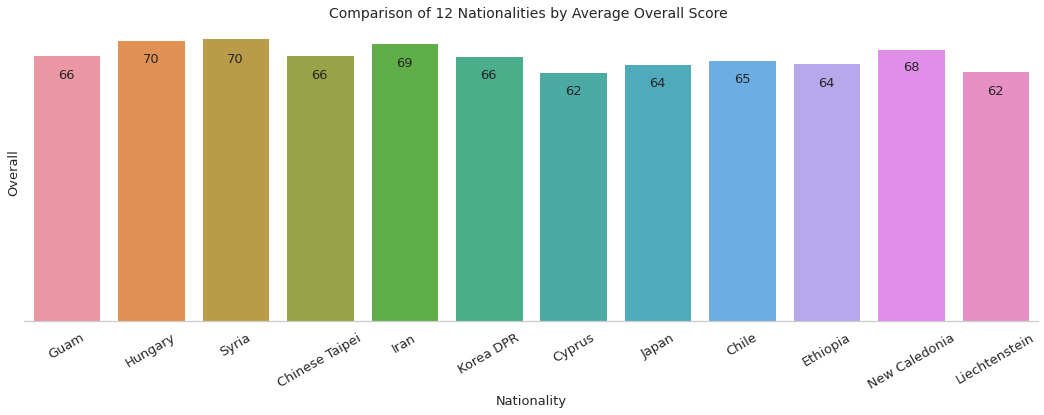

In [23]:
sample_overall_nationalities = mean_overall_by_nationality.sort_values(by=['overall'], ascending=False).sample(n=12)

plot_overall_by_nationality(sample_overall_nationalities)

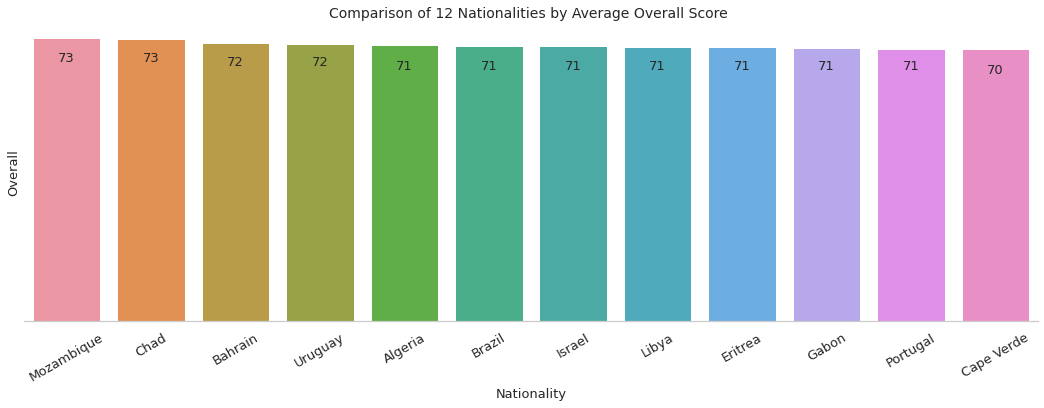

In [24]:
top_overall_nationalities = mean_overall_by_nationality.sort_values(by=['overall'], ascending=False)[:12]

plot_overall_by_nationality(top_overall_nationalities)

### **Age**

Youngest players in the world

In [25]:
youngest_players = data.loc[data['age'] == data['age'].min()]
youngest_players[['short_name', 'age', 'nationality', 'club']].sort_values(by=['short_name'])

,short_name,age,nationality,club
4764,A. Hložek,16,Czech Republic,Sparta Praha
14626,A. Velasco,16,Argentina,Independiente
17827,D. Burns,16,Northern Ireland,St. Patrick's Athletic
17614,D. Obbekjær,16,Denmark,Odense Boldklub
12158,E. Millot,16,France,AS Monaco
18243,E. Sartorius,16,England,Lincoln City
6630,Fábio Silva,16,Portugal,FC Porto
18171,J. Starbuck,16,England,Grimsby Town
18031,O. Stefánsson,16,Iceland,IFK Norrköping
18242,R. Wikberg,16,Sweden,Östersunds FK


Youngest players by club

In [26]:
group_by_club = data.groupby('club')

In [27]:
youngest = group_by_club.agg(youngest_age=('age', 'min'))
youngest.sort_values(by=['youngest_age'], ascending=True, inplace=True)

youngest.head()

,youngest_age
club,
Lincoln City,16
Independiente,16
IFK Norrköping,16
Grimsby Town,16
St. Patrick's Athletic,16


Oldest players in the world

In [30]:
oldest_players = data.loc[data['age'] == data['age'].max()]
oldest_players[['short_name', 'age', 'nationality', 'club']].sort_values(by=['short_name'])

,short_name,age,nationality,club
11832,C. Muñoz,42,Argentina,CD Universidad de Concepción
13003,H. Sulaimani,42,Saudi Arabia,Al Ahli


### **Wage**

Wage distribution

In [31]:
min_wage, max_wage = data['wage_eur'].min(), data['wage_eur'].max()
print(min_wage, max_wage)

0 565000


Wage-to-Age distribution

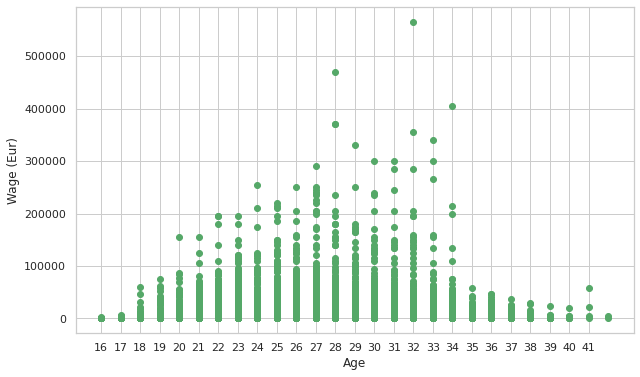

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(data['age'], data['wage_eur'], color='g')
plt.xticks(np.arange(data['age'].min(), data['age'].max()))
plt.xlabel('Age')
plt.ylabel('Wage (Eur)')

plt.show()

Take a closer look at wages that fall below 100,000 euros:

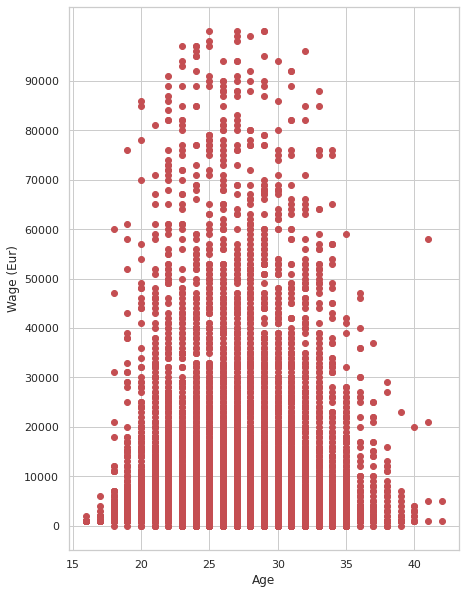

In [82]:
less_than_1hk_wages = data[data['wage_eur'] <= 100000]

plt.figure(figsize=(7, 10))

plt.scatter(less_than_1hk_wages['age'], less_than_1hk_wages['wage_eur'], color='r')
# plt.xticks(np.arange(less_than_1hk_wages['age'].min(), less_than_1hk_wages['age'].max()))
plt.yticks(np.arange(0, 100000, 10000))
plt.xlabel('Age')
plt.ylabel('Wage (Eur)')

plt.show()

Who are the highest paid players?

In [49]:
highest_paid = data.sort_values(by='wage_eur', ascending=False)[:30]

highest_paid_df = highest_paid[['short_name', 'age', 'nationality', 'club', 'overall', 'wage_eur', 'value_eur']]
highest_paid_df.head()

,short_name,age,nationality,club,overall,wage_eur,value_eur
0,L. Messi,32,Argentina,FC Barcelona,94,565000,95500000
4,E. Hazard,28,Belgium,Real Madrid,91,470000,90000000
1,Cristiano Ronaldo,34,Portugal,Juventus,93,405000,58500000
5,K. De Bruyne,28,Belgium,Manchester City,91,370000,90000000
22,A. Griezmann,28,France,FC Barcelona,89,370000,69000000


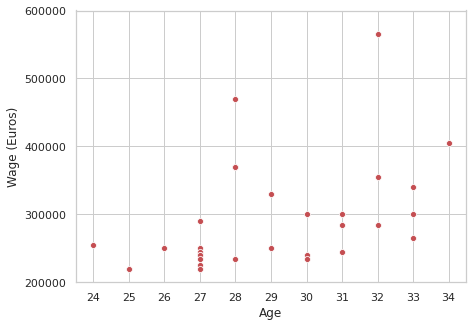

In [83]:
plt.figure(figsize=(7,5))

sns.scatterplot(highest_paid_df['age'], highest_paid_df['wage_eur'], color='r')
plt.xticks(np.arange(highest_paid_df['age'].min(), highest_paid_df['age'].max()+1))
plt.yticks(np.arange(200000, 600001, 100000))
plt.xlabel('Age')
plt.ylabel('Wage (Euros)')

plt.show()